<center><h1 style="font-family: Times New Roman, sans-serif; color: #e1111; font-size: 35px;"> Predictive Analysis of Aircraft Engines & Aviation Safety </h1></center>

## 1. Importing Important Libraries

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, classification_report,accuracy_score

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

In [3]:
# We will set the seed for reproducibility.
np.random.seed(1234)  
PYTHONHASHSEED = 0

## 2. Loading the Dataset

In [4]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_excel(r"C:\Users\Lokesh Patra\Documents\Projects\Minor Project\PM_train.xlsx")

# Test data where the failure point is not given for the engines
test_df = pd.read_excel(r"C:\Users\Lokesh Patra\Documents\Projects\Minor Project\PM_test.xlsx")

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  int64  
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

## 3. Data Preprocessing

In [6]:
# Let's drop the NAN columns 26 and 27 using the dropna() method.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [7]:
train_df.drop(['s1','s5','s10','s16','s18','s19','s20','s21'],axis=1,inplace=True)
test_df.drop(['s1','s5','s10','s16','s18','s19','s20','s21'],axis=1,inplace=True)

In [8]:
print(len(train_df))
print(len(test_df))

20631
11939


In [9]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's2', 's3',
                     's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14',
                     's15', 's17']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head(2)

,id,cycle,setting1,setting2,setting3,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17
0,1,1,-0.0007,-0.0004,100,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392
1,1,2,0.0019,-0.0003,100,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392


In [10]:
test_df.head(2)

,id,cycle,setting1,setting2,setting3,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17
0,1,1,0.0023,0.0003,100,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.2,521.72,2388.03,8125.55,8.4052,392.0
1,1,2,-0.0027,-0.0003,100,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.5,522.16,2388.06,8139.62,8.3803,393.0


In [11]:
test_df['id'].value_counts()

id
49    303
91    234
62    232
12    217
81    213
     ... 
14     46
22     39
39     37
85     34
1      31
Name: count, Length: 92, dtype: int64

In [12]:
# method and specify which columns are to be considered while sorting using the parameter. 
train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

In [13]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [14]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
test_df = test_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
test_df['RUL'] = test_df['max'] - test_df['cycle']

#The RUL is calculated for each id.
test_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,31,30
1,1,2,31,29
2,1,3,31,28
3,1,4,31,27
4,1,5,31,26


In [15]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)
test_df.drop('max', axis=1, inplace=True)

In [16]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )

In [17]:
train_df[train_df['RUL']<w1].shape

(3000, 20)

In [18]:
test_df[test_df['RUL']<w1].shape

(2760, 20)

In [19]:
train_df.shape , test_df.shape

((20631, 20), (11939, 20))

In [20]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s2,s3,s4,s6,s7,...,s9,s11,s12,s13,s14,s15,s17,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.183735,0.406802,0.309757,1.0,0.726248,...,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.283133,0.453019,0.352633,1.0,0.628019,...,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.343373,0.369523,0.370527,1.0,0.710145,...,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.343373,0.256159,0.331195,1.0,0.740741,...,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.349398,0.257467,0.404625,1.0,0.668277,...,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,187,0,0.01108


In [21]:
#train_df.desc()

In [22]:
# We will perform MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s2,s3,s4,s6,s7,...,s9,s11,s12,s13,s14,s15,s17,RUL,failure_within_w1,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.545181,0.310661,0.269413,1.0,0.652174,...,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,30,1,0.00000
1,1,2,0.344828,0.250000,0.0,0.150602,0.379551,0.222316,1.0,0.805153,...,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,29,1,0.00277
2,1,3,0.517241,0.583333,0.0,0.376506,0.346632,0.322248,1.0,0.685990,...,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,28,1,0.00554
3,1,4,0.741379,0.500000,0.0,0.370482,0.285154,0.408001,1.0,0.679549,...,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,27,1,0.00831
4,1,5,0.580460,0.500000,0.0,0.391566,0.352082,0.332039,1.0,0.694042,...,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,26,1,0.01108


In [23]:
print(train_df['failure_within_w1'].value_counts())

failure_within_w1
0    17531
1     3100
Name: count, dtype: int64


In [24]:
train_df['cycle_norm'].nunique()

362

In [25]:
train_df.drop('cycle',axis=1,inplace=True)
test_df.drop('cycle',axis=1,inplace=True)
# train_df.drop('RUL',axis=1,inplace=True)
# test_df.drop('RUL',axis=1,inplace=True)

## 4. Exploratory Data Analysis [EDA]

<Axes: >

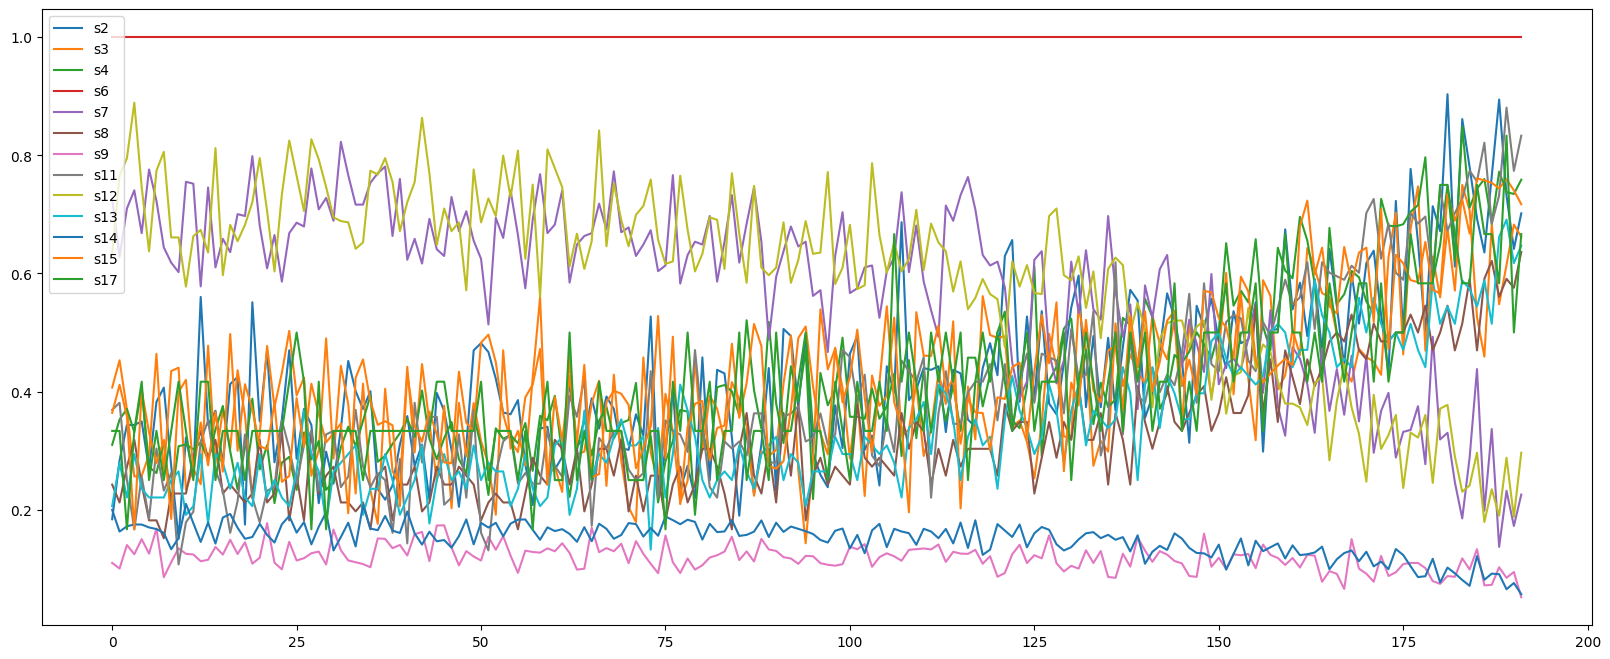

In [26]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<Axes: >

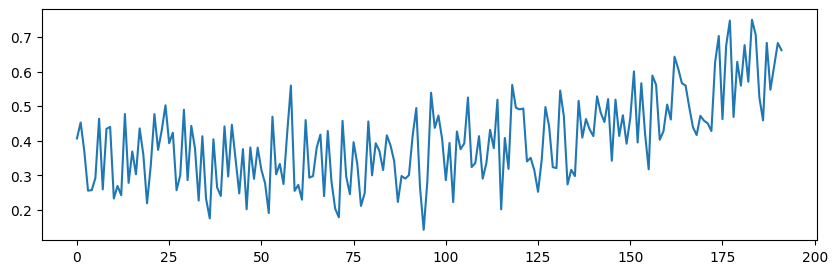

In [27]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

<ol>
    <li> Sensor 1 values increase when the cycle of number incrceases.</li>
    <li> Sensor 6 values decrease when the cycle of number increases.</li>
    <li> Most other sensors exhibit either an increasing or decreasing trend.</li>
</ol>

<Axes: >

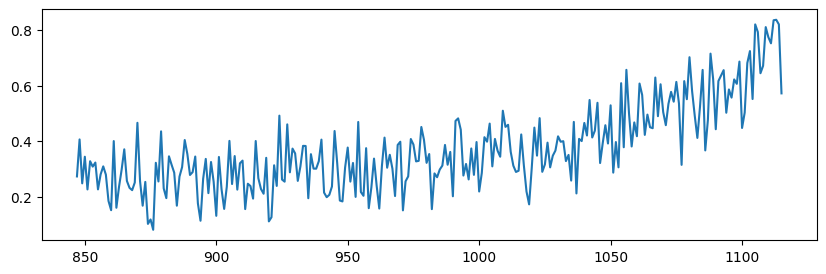

In [28]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

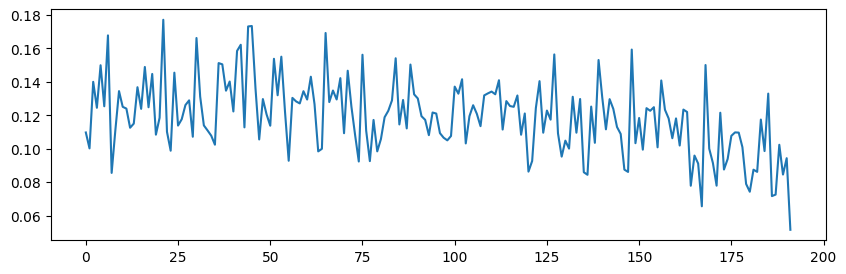

In [29]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

#We have plotted sensor1 observations for id 1 and id 5.
#Both observations have an upward trend with increasing cycles.

<Axes: >

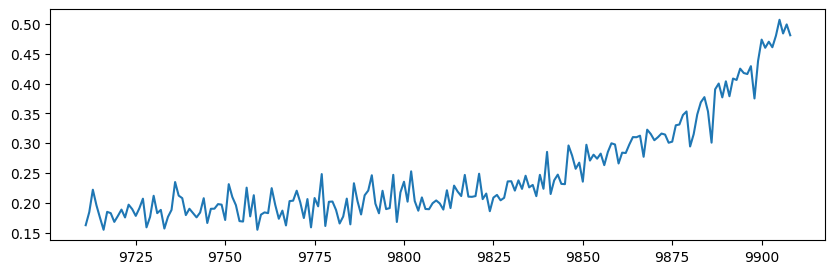

In [30]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

#We have plotted sensor6 observations for id 1 and id 50.
#Both observations have a downward trend with increasing cycles.
#We can sew that when the sensor values approach a particular value, the aircraft may fail to work soon.

In [31]:
train_df.isnull().sum()

id                   0
setting1             0
setting2             0
setting3             0
s2                   0
s3                   0
s4                   0
s6                   0
s7                   0
s8                   0
s9                   0
s11                  0
s12                  0
s13                  0
s14                  0
s15                  0
s17                  0
RUL                  0
failure_within_w1    0
cycle_norm           0
dtype: int64

<Axes: >

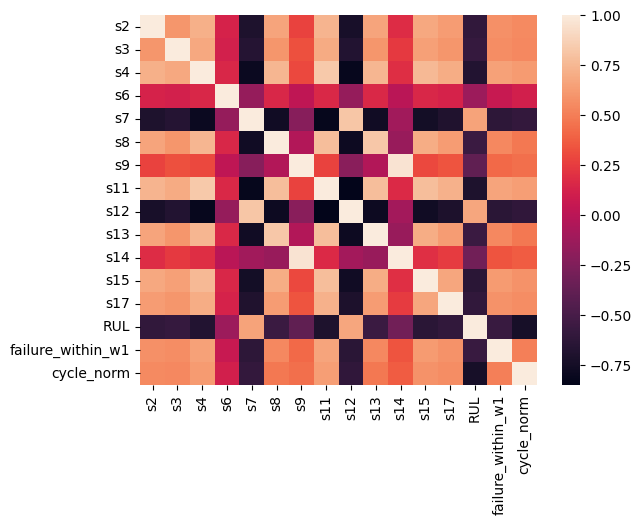

In [32]:
sns.heatmap(train_df.drop(["id","setting1","setting2","setting3"],axis=1).corr())

## 5. X and Y Split

In [33]:
'''x_train = train_df.drop(['failure_within_w1'],axis=1)
y_train = train_df['failure_within_w1']
x_test = test_df.drop(['failure_within_w1'],axis=1)
y_test = test_df['failure_within_w1']'''

"x_train = train_df.drop(['failure_within_w1'],axis=1)\ny_train = train_df['failure_within_w1']\nx_test = test_df.drop(['failure_within_w1'],axis=1)\ny_test = test_df['failure_within_w1']"

In [34]:
df= pd.read_excel(r"C:\Users\Lokesh Patra\Documents\Projects\Minor Project\PM_train.xlsx")
df.drop(['s1','s5','s10','s16','s18','s19','s20','s21'],axis=1,inplace=True)

#Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
df = df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
df['RUL'] = df['max'] - df['cycle']

#The RUL is calculated for each id.
df[['id','cycle','max','RUL']].head()

# Make a separate feature for the normalized value of the cycle column.
df['cycle_norm'] = df['cycle']

w1 = 30
df['failure_within_w1'] = np.where(df['RUL'] <= w1, 1, 0 )
df['cycle_norm'] = df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
df = join_df.reindex(columns = df.columns)

df.head()

,id,cycle,setting1,setting2,setting3,s2,s3,s4,s6,s7,...,s11,s12,s13,s14,s15,s17,max,RUL,cycle_norm,failure_within_w1
0,1,1,0.459770,0.166667,0.0,0.183735,0.406802,0.309757,1.0,0.726248,...,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.273504,191,0.00000,0
1,1,2,0.609195,0.250000,0.0,0.283133,0.453019,0.352633,1.0,0.628019,...,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.273504,190,0.00277,0
2,1,3,0.252874,0.750000,0.0,0.343373,0.369523,0.370527,1.0,0.710145,...,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.273504,189,0.00554,0
3,1,4,0.540230,0.500000,0.0,0.343373,0.256159,0.331195,1.0,0.740741,...,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.273504,188,0.00831,0
4,1,5,0.390805,0.333333,0.0,0.349398,0.257467,0.404625,1.0,0.668277,...,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.273504,187,0.01108,0


In [35]:
X = df.iloc [:, :-1]
y = df.iloc [:, -1]

In [36]:
df.head()

,id,cycle,setting1,setting2,setting3,s2,s3,s4,s6,s7,...,s11,s12,s13,s14,s15,s17,max,RUL,cycle_norm,failure_within_w1
0,1,1,0.459770,0.166667,0.0,0.183735,0.406802,0.309757,1.0,0.726248,...,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.273504,191,0.00000,0
1,1,2,0.609195,0.250000,0.0,0.283133,0.453019,0.352633,1.0,0.628019,...,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.273504,190,0.00277,0
2,1,3,0.252874,0.750000,0.0,0.343373,0.369523,0.370527,1.0,0.710145,...,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.273504,189,0.00554,0
3,1,4,0.540230,0.500000,0.0,0.343373,0.256159,0.331195,1.0,0.740741,...,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.273504,188,0.00831,0
4,1,5,0.390805,0.333333,0.0,0.349398,0.257467,0.404625,1.0,0.668277,...,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.273504,187,0.01108,0


In [37]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,y)

In [38]:
y_train.value_counts()

failure_within_w1
0    13139
1     2334
Name: count, dtype: int64

In [39]:
x_train.shape

(15473, 21)

In [40]:
x_train, y_train = SMOTE().fit_resample(x_train, y_train)

In [41]:
x_train.shape

(26278, 21)

In [42]:
y_train.value_counts()

failure_within_w1
0    13139
1    13139
Name: count, dtype: int64

## 6. Model Building

# AeroSense
### 7.0.0 Sigmoid Function

In [43]:
#Sigmoid Function
import numpy as np

class AeroSense:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Initialize weights and bias
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)

            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

In [44]:
# Sigmoid
aeroSenseClassifier = AeroSense()
aeroSenseClassifier.fit(x_train, y_train)
y_pred_aerosense = aeroSenseClassifier.predict(x_test)
aerosense_sigmoid = accuracy_score(y_test, y_pred_aerosense)
print('Sigmoid Accuracy: {:.2f}%'.format(aerosense_sigmoid * 100))
print(classification_report(y_test, y_pred_aerosense))
print(confusion_matrix(y_test, y_pred_aerosense))

Sigmoid Accuracy: 97.62%
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4392
           1       0.94      0.89      0.92       766

    accuracy                           0.98      5158
   macro avg       0.96      0.94      0.95      5158
weighted avg       0.98      0.98      0.98      5158

[[4350   42]
 [  81  685]]


Sigmoid Accuracy: 97.62%
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4392
           1       0.94      0.89      0.92       766

    accuracy                           0.98      5158
   macro avg       0.96      0.94      0.95      5158
weighted avg       0.98      0.98      0.98      5158



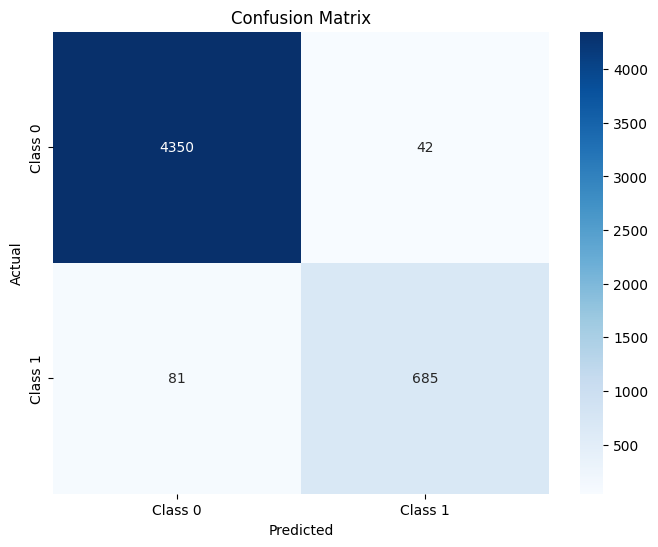

In [45]:
aerosense_sigmoid = accuracy_score(y_test, y_pred_aerosense)

print('Sigmoid Accuracy: {:.2f}%'.format(aerosense_sigmoid * 100))
print(classification_report(y_test, y_pred_aerosense))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_aerosense)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [46]:
# Save the model
joblib.dump(aeroSenseClassifier, 'aerosense_model.pkl')

['aerosense_model.pkl']

### 7.0.1 Hyperbolic Function

In [47]:
import numpy as np

class AeroSense:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def tanh(self, z):
        return np.tanh(z)

    def fit(self, X, y):
        # Initialize weights and bias
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.tanh(linear_model)

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)

            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.tanh(linear_model)
        y_predicted_cls = [1 if i > 0 else 0 for i in y_predicted]  # using 0 as threshold for tanh
        return np.array(y_predicted_cls)

In [48]:
# Hyperbolic
aeroSenseClassifier = AeroSense()
aeroSenseClassifier.fit(x_train, y_train)
y_pred_aerosense = aeroSenseClassifier.predict(x_test)
aerosense_hyper = accuracy_score(y_test, y_pred_aerosense)
print('Hyperbolic Accuracy: {:.2f}%'.format(aerosense_hyper * 100))
print(classification_report(y_test, y_pred_aerosense))
print(confusion_matrix(y_test, y_pred_aerosense))

Hyperbolic Accuracy: 37.30%
              precision    recall  f1-score   support

           0       1.00      0.26      0.42      4392
           1       0.19      1.00      0.32       766

    accuracy                           0.37      5158
   macro avg       0.60      0.63      0.37      5158
weighted avg       0.88      0.37      0.40      5158

[[1158 3234]
 [   0  766]]


### PreBuilt Models

### 6.1 Logistic Regression

In [49]:
# Logistic Regression
LRclassifier = LogisticRegression(solver='liblinear', max_iter=5000)
LRclassifier.fit(x_train, y_train)
y_pred_lr = LRclassifier.predict(x_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print('Logistic Regression Accuracy: {:.2f}%'.format(lr_accuracy * 100))
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Accuracy: 99.53%
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4392
           1       0.97      1.00      0.98       766

    accuracy                           1.00      5158
   macro avg       0.99      1.00      0.99      5158
weighted avg       1.00      1.00      1.00      5158

[[4369   23]
 [   1  765]]


### 6.2 KNN Classification

In [50]:
# K Nearest Neighbors
KNclassifier = KNeighborsClassifier(n_neighbors=20)
KNclassifier.fit(x_train, y_train)
y_pred_knn = KNclassifier.predict(x_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print('K Nearest Neighbors Accuracy: {:.2f}%'.format(knn_accuracy * 100))
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))

K Nearest Neighbors Accuracy: 98.41%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4392
           1       0.90      1.00      0.95       766

    accuracy                           0.98      5158
   macro avg       0.95      0.99      0.97      5158
weighted avg       0.99      0.98      0.98      5158

[[4311   81]
 [   1  765]]


In [51]:
# K Neighbors Classifier - Model Tuning
score_list_knn = []
for i in range(1, 30):
    knn_classifier = KNeighborsClassifier(n_neighbors=i)
    knn_classifier.fit(x_train, y_train)
    score_list_knn.append(knn_classifier.score(x_test, y_test))

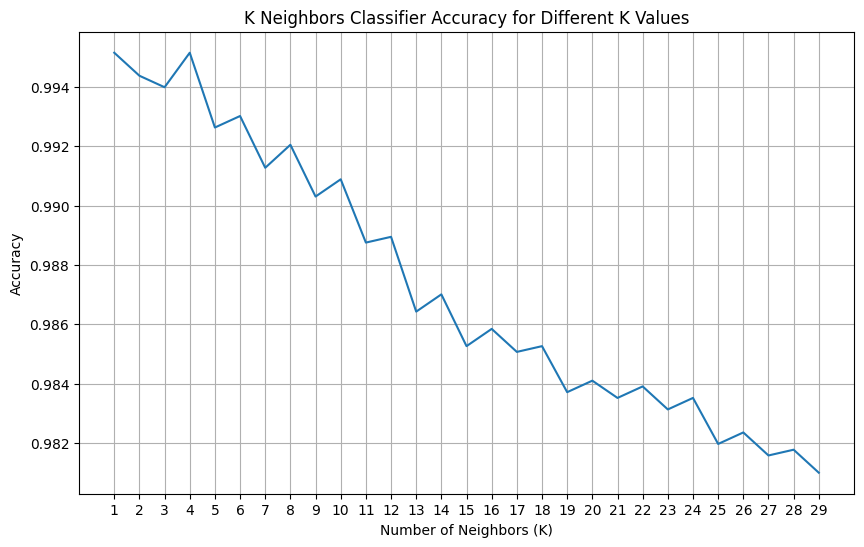

In [52]:
# Plot K Neighbors Classifier - Model Tuning
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), score_list_knn)
plt.title('K Neighbors Classifier Accuracy for Different K Values')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 30, 1))
plt.grid(True)
plt.show()

### 6.3 SVM

In [53]:
# Support Vector Machine
SVCclassifier = SVC(kernel='linear', max_iter=251)
SVCclassifier.fit(x_train, y_train)
y_pred_svc = SVCclassifier.predict(x_test)
svc_accuracy = accuracy_score(y_test, y_pred_svc)
SVCAcc = svc_accuracy * 100 # Assigning the accuracy value to SVCAcc
print('SVM Accuracy: {:.2f}%'.format(SVCAcc))
print(classification_report(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))

SVM Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4392
           1       1.00      1.00      1.00       766

    accuracy                           1.00      5158
   macro avg       1.00      1.00      1.00      5158
weighted avg       1.00      1.00      1.00      5158

[[4392    0]
 [   0  766]]


C:\Users\Lokesh Patra\AppData\Roaming\Python\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=251).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### 6.4 GaussianNB

In [54]:
# Naive Bayes - GaussianNB
NBclassifier2 = GaussianNB()
NBclassifier2.fit(x_train, y_train)
y_pred_nb2 = NBclassifier2.predict(x_test)
nb_accuracy2 = accuracy_score(y_test, y_pred_nb2)
print('GaussianNB Accuracy: {:.2f}%'.format(nb_accuracy2 * 100))
print(classification_report(y_test, y_pred_nb2))
print(confusion_matrix(y_test, y_pred_nb2))

GaussianNB Accuracy: 93.16%
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4392
           1       0.69      0.99      0.81       766

    accuracy                           0.93      5158
   macro avg       0.84      0.96      0.88      5158
weighted avg       0.95      0.93      0.94      5158

[[4047  345]
 [   8  758]]


### 6.5 Decision Tree

In [55]:
# Decision Tree
DTclassifier = DecisionTreeClassifier(max_leaf_nodes=20)
DTclassifier.fit(x_train, y_train)
y_pred_dt = DTclassifier.predict(x_test)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print('Decision Tree Accuracy: {:.2f}%'.format(dt_accuracy * 100))
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))

Decision Tree Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4392
           1       1.00      1.00      1.00       766

    accuracy                           1.00      5158
   macro avg       1.00      1.00      1.00      5158
weighted avg       1.00      1.00      1.00      5158

[[4392    0]
 [   0  766]]


### 6.6 Random Forest

In [56]:
# Random Forest
RFclassifier = RandomForestClassifier(max_leaf_nodes=30)
RFclassifier.fit(x_train, y_train)
y_pred_rf = RFclassifier.predict(x_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print('Random Forest Accuracy: {:.2f}%'.format(rf_accuracy * 100))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4392
           1       1.00      1.00      1.00       766

    accuracy                           1.00      5158
   macro avg       1.00      1.00      1.00      5158
weighted avg       1.00      1.00      1.00      5158

[[4392    0]
 [   0  766]]


## 7. Model Comparison

In [57]:
import pandas as pd
# Define the accuracy scores for each model
accuracy_scores = {
    'AeroSense Sigmoid' : aerosense_sigmoid * 100,
    'AeroSense Hyperbolic' : aerosense_hyper * 100,
    'Logistic Regression': lr_accuracy * 100,
    'K-Nearest Neighbour': knn_accuracy * 100,
    'Support Vector Machine': SVCAcc,
    'Gaussian Naive Bayes': nb_accuracy2 * 100,
    'Decision Tree': dt_accuracy * 100,
    'Random Forest': rf_accuracy * 100
}

# Create DataFrame for model comparison
model_comparison = pd.DataFrame(accuracy_scores.items(), columns=['Model', 'Accuracy'])

# Sort the DataFrame by Accuracy in descending order
model_comparison.sort_values(by='Accuracy', ascending=False, inplace=False)

# Print the sorted DataFrame
model_comparison

,Model,Accuracy
0,AeroSense Sigmoid,97.615355
1,AeroSense Hyperbolic,37.301280
2,Logistic Regression,99.534703
3,K-Nearest Neighbour,98.410237
4,Support Vector Machine,100.000000
5,Gaussian Naive Bayes,93.156262
6,Decision Tree,100.000000
7,Random Forest,100.000000


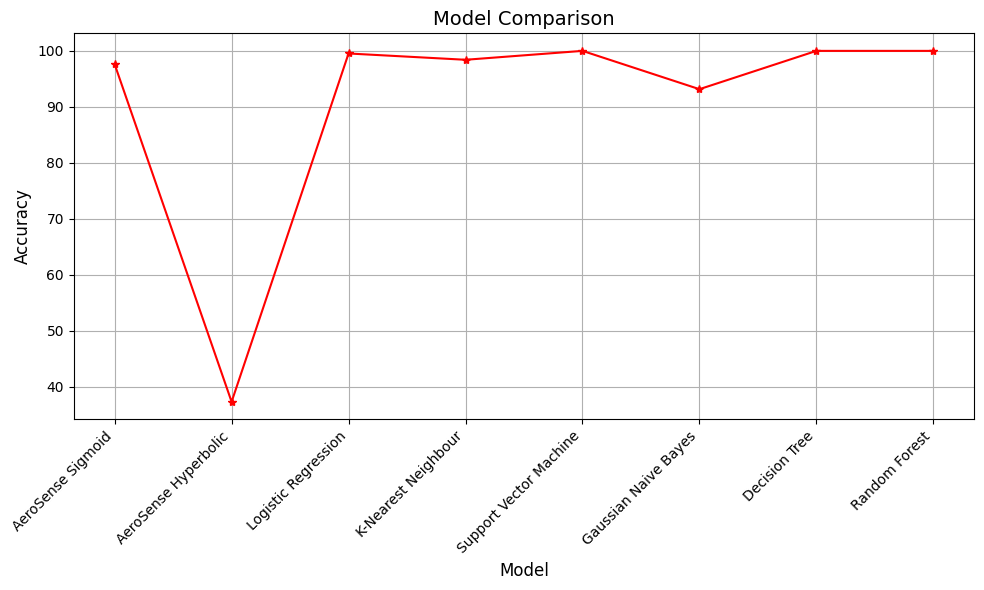

In [58]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the data
plt.plot(model_comparison['Model'], model_comparison['Accuracy'], marker='*', color='r', linestyle='-')

# Rotate x-axis ticks
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust rotation, alignment, and font size of ticks

# Set labels and title
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Comparison', fontsize=14)

# Show grid
plt.grid(True)

# Show plot
plt.tight_layout()  # Adjust layout
plt.show()

In [59]:
'''import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
import numpy as np

class AeroSense:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Initialize weights and bias
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)

            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_predicted_cls = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

class PredictiveMaintenanceGUI:
    def __init__(self, root, model, min_values, max_values):
        self.root = root
        self.root.title("Predictive Maintenance")
        self.model = model
        self.min_values = min_values
        self.max_values = max_values
        
        self.num_sensors = 21
        
        # Create a canvas with a vertical scrollbar
        self.canvas = tk.Canvas(root)
        self.canvas.pack(side="left", fill="both", expand=True)
        self.scrollbar = tk.Scrollbar(root, orient="vertical", command=self.canvas.yview)
        self.scrollbar.pack(side="right", fill="y")
        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        
        # Create a frame to contain the widgets
        self.frame = tk.Frame(self.canvas)
        self.canvas.create_window((0, 0), window=self.frame, anchor="nw")
        
        self.create_widgets()
    
    def create_widgets(self):
        predict_button = tk.Button(self.frame, text=" [Binary] Predict Engine Condition ", command=self.predict)
        predict_button.grid(row=0, columnspan=2, padx=10, pady=10)
        
        self.sensor_sliders = []
        for i in range(1, self.num_sensors + 1):
            sensor_label = tk.Label(self.frame, text=f"Sensor {i}:")
            sensor_label.grid(row=i, column=0, padx=10, pady=5, sticky=tk.W)
            sensor_slider = tk.Scale(self.frame, from_=self.min_values[i-1], to=self.max_values[i-1], orient=tk.HORIZONTAL)
            sensor_slider.grid(row=i, column=1, padx=10, pady=5)
            self.sensor_sliders.append(sensor_slider)
    
    def predict(self):
        try:
            sensor_values = [slider.get() for slider in self.sensor_sliders]
            sensor_array = np.array(sensor_values).reshape(1, -1)
            prediction = self.model.predict(sensor_array)
            messagebox.showinfo("Engine Condition", f"Predicted Engine Condition: {prediction[0]}")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to predict engine condition: {e}")

def main():
    # Load the trained model
    try:
        model = AeroSense(learning_rate=0.01, num_iterations=1000)  # Adjust these values as needed
        
        # Placeholder training data (replace with your actual training data)
        x_train = np.random.rand(100, 21)  # Example: 100 samples, 21 features
        y_train = np.random.randint(2, size=100)  # Example: Binary classification labels
        
        model.fit(x_train, y_train)  # Train the model with the training data
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load model: {e}")
        return
    
    # Minimum and maximum sensor values
    min_values = [518.6700, 641.2100, 1571.0400, 1382.2500, 14.6200, 21.6000, 549.8500, 2387.9000, 9021.7300, 1.3000, 46.8500, 518.6900, 2387.8800, 8099.9400, 8.3249, 0.0300, 388.0000, 2388.0000, 100.0000, 38.1400, 22.8942]
    max_values = [518.6700, 644.5300, 1616.9100, 1441.4900, 14.6200, 21.6100, 556.0600, 2388.5600, 9244.5900, 1.3000, 48.5300, 523.3800, 2388.5600, 8293.7200, 8.5848, 0.0300, 400.0000, 2388.0000, 100.0000, 39.4300, 23.6184]

    root = tk.Tk()
    app = PredictiveMaintenanceGUI(root, model, min_values, max_values)
    root.mainloop()

if __name__ == "__main__":
    main()'''

'import tkinter as tk\nfrom tkinter import messagebox\nfrom tkinter import ttk\nimport numpy as np\n\nclass AeroSense:\n    def __init__(self, learning_rate=0.01, num_iterations=1000):\n        self.learning_rate = learning_rate\n        self.num_iterations = num_iterations\n        self.weights = None\n        self.bias = None\n\n    def sigmoid(self, z):\n        return 1 / (1 + np.exp(-z))\n\n    def fit(self, X, y):\n        # Initialize weights and bias\n        num_samples, num_features = X.shape\n        self.weights = np.zeros(num_features)\n        self.bias = 0\n\n        # Gradient descent\n        for _ in range(self.num_iterations):\n            linear_model = np.dot(X, self.weights) + self.bias\n            y_predicted = self.sigmoid(linear_model)\n\n            # Compute gradients\n            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))\n            db = (1 / num_samples) * np.sum(y_predicted - y)\n\n            # Update parameters\n            self.weights -

In [60]:
class PredictiveMaintenanceGUI:
    def __init__(self, root, model, min_values, max_values):
        self.root = root
        self.root.title("Predictive Maintenance")
        self.model = model
        self.min_values = min_values
        self.max_values = max_values
        
        self.num_sensors = 21
        
        # Create a canvas with a vertical scrollbar
        self.canvas = tk.Canvas(root)
        self.canvas.pack(side="left", fill="both", expand=True)
        self.scrollbar = tk.Scrollbar(root, orient="vertical", command=self.canvas.yview)
        self.scrollbar.pack(side="right", fill="y")
        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        
        # Create a frame to contain the widgets
        self.frame = tk.Frame(self.canvas)
        self.canvas.create_window((0, 0), window=self.frame, anchor="nw")
        
        self.create_widgets()
    
    def create_widgets(self):
        predict_button = tk.Button(self.frame, text="Predict Engine Condition", command=self.predict)
        predict_button.grid(row=0, columnspan=2, padx=10, pady=10)
        
        self.sensor_sliders = []
        for i in range(1, self.num_sensors + 1):
            sensor_label = tk.Label(self.frame, text=f"Sensor {i}:")
            sensor_label.grid(row=i, column=0, padx=10, pady=5, sticky=tk.W)
            sensor_slider = tk.Scale(self.frame, from_=self.min_values[i-1], to=self.max_values[i-1], orient=tk.HORIZONTAL)
            sensor_slider.grid(row=i, column=1, padx=10, pady=5)
            self.sensor_sliders.append(sensor_slider)
    
    def predict(self):
        try:
            sensor_values = [slider.get() for slider in self.sensor_sliders]
            sensor_array = np.array(sensor_values).reshape(1, -1)
            prediction = self.model.predict(sensor_array)
            if prediction[0] == 1:
                messagebox.showinfo("Engine Condition", "Engine Passed")
            else:
                messagebox.showinfo("Engine Condition", "Engine Failure")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to predict engine condition: {e}")

def main():
    # Load the trained model
    try:
        model = AeroSense(learning_rate=0.01, num_iterations=1000)  # Adjust these values as needed
        
        # Placeholder training data (replace with your actual training data)
        x_train = np.random.rand(100, 21)  # Example: 100 samples, 21 features
        y_train = np.random.randint(2, size=100)  # Example: Binary classification labels
        
        model.fit(x_train, y_train)  # Train the model with the training data
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load model: {e}")
        return
    
    # Minimum and maximum sensor values
    min_values = [518.6700, 641.2100, 1571.0400, 1382.2500, 14.6200, 21.6000, 549.8500, 2387.9000, 9021.7300, 1.3000, 46.8500, 518.6900, 2387.8800, 8099.9400, 8.3249, 0.0300, 388.0000, 2388.0000, 100.0000, 38.1400, 22.8942]
    max_values = [518.6700, 644.5300, 1616.9100, 1441.4900, 14.6200, 21.6100, 556.0600, 2388.5600, 9244.5900, 1.3000, 48.5300, 523.3800, 2388.5600, 8293.7200, 8.5848, 0.0300, 400.0000, 2388.0000, 100.0000, 39.4300, 23.6184]

    root = tk.Tk()
    app = PredictiveMaintenanceGUI(root, model, min_values, max_values)
    root.mainloop()

if __name__ == "__main__":
    main()

In [66]:
import tkinter as tk

# Define function to get engine condition based on prediction
def get_engine_condition(predictions):
    conditions = []
    for prediction in predictions:
        if prediction > 0.8:
            conditions.append("Perfect")
        elif prediction > 0.6:
            conditions.append("Good")
        elif prediction > 0.4:
            conditions.append("Neutral")
        else:
            conditions.append("Bad")
    return conditions

# Define function to predict engine condition
def predict_engine_condition():
    try:
        # Get sensor data from sliders
        sensor1 = sensor1_slider.get()
        sensor2 = sensor2_slider.get()
        sensor3 = sensor3_slider.get()
        sensor4 = sensor4_slider.get()
        sensor5 = sensor5_slider.get()

        # Perform some dummy calculations 
        prediction = (sensor1 + sensor2 + sensor3 + sensor4 + sensor5) / 5

        # Get engine condition
        engine_condition = get_engine_condition([prediction])

        # Update result label
        result_label.config(text=f"Engine Condition: {engine_condition[0]}")
    except Exception as e:
        result_label.config(text="An error occurred during prediction.")

# Create GUI
root = tk.Tk()
root.title("Engine Condition Predictor")

# Sensor sliders
sensor1_label = tk.Label(root, text="Sensor 1:")
sensor1_label.grid(row=0, column=0, padx=5, pady=5)
sensor1_slider = tk.Scale(root, from_=0.0, to=1.0, orient="horizontal", resolution=0.01)
sensor1_slider.grid(row=0, column=1, padx=5, pady=5)

sensor2_label = tk.Label(root, text="Sensor 2:")
sensor2_label.grid(row=1, column=0, padx=5, pady=5)
sensor2_slider = tk.Scale(root, from_=0.0, to=1.0, orient="horizontal", resolution=0.01)
sensor2_slider.grid(row=1, column=1, padx=5, pady=5)

sensor3_label = tk.Label(root, text="Sensor 3:")
sensor3_label.grid(row=2, column=0, padx=5, pady=5)
sensor3_slider = tk.Scale(root, from_=0.0, to=1.0, orient="horizontal", resolution=0.01)
sensor3_slider.grid(row=2, column=1, padx=5, pady=5)

sensor4_label = tk.Label(root, text="Sensor 4:")
sensor4_label.grid(row=3, column=0, padx=5, pady=5)
sensor4_slider = tk.Scale(root, from_=0.0, to=1.0, orient="horizontal", resolution=0.01)
sensor4_slider.grid(row=3, column=1, padx=5, pady=5)

sensor5_label = tk.Label(root, text="Sensor 5:")
sensor5_label.grid(row=4, column=0, padx=5, pady=5)
sensor5_slider = tk.Scale(root, from_=0.0, to=1.0, orient="horizontal", resolution=0.01)
sensor5_slider.grid(row=4, column=1, padx=5, pady=5)

# Predict button
predict_button = tk.Button(root, text="Predict Engine Condition", command=predict_engine_condition)
predict_button.grid(row=5, column=0, columnspan=2, padx=5, pady=5)

# Result label
result_label = tk.Label(root, text="")
result_label.grid(row=6, column=0, columnspan=2, padx=5, pady=5)

root.mainloop()

In [62]:
//Light

SyntaxError: invalid syntax (1429618301.py, line 1)